In [1]:
import numpy as np
import pandas as pd
import json 
import os
import shutil
from tqdm import tqdm
import pyarrow.parquet as pq
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import math
import matplotlib.pyplot as plt
tf.random.set_seed(42)
np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as file:
    char_to_num = json.load(file)
    
        
PAD = 'P'
SOS = '<'
EOS = '>'
dict_size = len(char_to_num)
char_to_num[PAD] = dict_size
char_to_num[SOS] = dict_size + 1
char_to_num[EOS] = dict_size + 2
num_to_char = {j:i for i, j in char_to_num.items()}

In [3]:
DEBUG = False
batch_size = 64
layer_norm_eps = 1e-6
n_attention_heads = 4
# model_dimension = 512
dropout_ratio = 0.1
feed_forward_expand_ratio = 2
encoder_embedding_dim = 384
decoder_embedding_dim = 256
seed = 42
vocab_size = len(char_to_num)
max_src_length = 128
max_tgt_length = 32
n_encoders = 4
n_decoders = 2
embedding_dropout = 0.0
feed_dropout = 0.30
mha_dropout = 0.2
classfier_dropout = 0.10

In [4]:
char_to_num

{' ': 0,
 '!': 1,
 '#': 2,
 '$': 3,
 '%': 4,
 '&': 5,
 "'": 6,
 '(': 7,
 ')': 8,
 '*': 9,
 '+': 10,
 ',': 11,
 '-': 12,
 '.': 13,
 '/': 14,
 '0': 15,
 '1': 16,
 '2': 17,
 '3': 18,
 '4': 19,
 '5': 20,
 '6': 21,
 '7': 22,
 '8': 23,
 '9': 24,
 ':': 25,
 ';': 26,
 '=': 27,
 '?': 28,
 '@': 29,
 '[': 30,
 '_': 31,
 'a': 32,
 'b': 33,
 'c': 34,
 'd': 35,
 'e': 36,
 'f': 37,
 'g': 38,
 'h': 39,
 'i': 40,
 'j': 41,
 'k': 42,
 'l': 43,
 'm': 44,
 'n': 45,
 'o': 46,
 'p': 47,
 'q': 48,
 'r': 49,
 's': 50,
 't': 51,
 'u': 52,
 'v': 53,
 'w': 54,
 'x': 55,
 'y': 56,
 'z': 57,
 '~': 58,
 'P': 59,
 '<': 60,
 '>': 61}

In [5]:
train_csv = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
if DEBUG:
    train_csv = train_csv[:5000]

In [6]:
train_csv.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [7]:
sample_pq = pd.read_parquet('/kaggle/input/asl-fingerspelling/'+train_csv.iloc[0, 0])

In [8]:
sample_pq.head()

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,2,0.711059,0.700858,0.706272,0.693285,0.700825,0.703319,0.711549,0.615606,0.715143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,3,0.712799,0.702518,0.707840,0.694899,0.702445,0.704794,0.712483,0.625044,0.715677,...,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282
1816796431,4,0.712349,0.705451,0.709918,0.696006,0.705180,0.706928,0.712685,0.614356,0.714875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
all_columns = list(sample_pq.columns)
rhand_x = [i for i in all_columns if 'right' in i and 'x' in i]
rhand_y = [i for i in all_columns if 'right' in i and 'y' in i]
lhand_x = [i for i in all_columns if 'left' in i and 'x' in i]
lhand_y = [i for i in all_columns if 'left' in i and 'y' in i]
rhand_x_idx = [idx for idx, i in enumerate(all_columns) if i in rhand_x]
rhand_y_idx = [idx for idx, i in enumerate(all_columns) if i in rhand_y]
lhand_x_idx = [idx for idx, i in enumerate(all_columns) if i in lhand_x]
lhand_y_idx = [idx for idx, i in enumerate(all_columns) if i in lhand_y]
lips_loc = [
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ]
lips_x = [i for idx, i in enumerate(all_columns) if 'x_face' in i and int(i.split('_')[-1]) in lips_loc]
lips_y = [i for idx, i in enumerate(all_columns) if 'y_face' in i and int(i.split('_')[-1]) in lips_loc]
lips_x_idx = [idx for idx, i in enumerate(all_columns) if i in lips_x]
lips_y_idx = [idx for idx, i in enumerate(all_columns) if i in lips_y]

In [10]:
selected_columns_idx = lhand_x_idx + lhand_y_idx + rhand_x_idx + rhand_y_idx +  lips_x_idx + lips_y_idx
selected_columns_names = lhand_x + lhand_y + rhand_x + rhand_y  + lips_x + lips_y
rhand = rhand_x + rhand_y
lhand = lhand_x + lhand_y
hand = rhand + lhand
ncols = len(selected_columns_idx)
print(f'Num features: {len(selected_columns_idx)}')

Num features: 164


In [11]:
class PreprocessLayer(keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        # Where this variable will be used ?
        self.normalisation_constant = tf.constant([
            0.50 if 'x' in name else 0.0 for name in lhand
        ], dtype=tf.float32)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,ncols], dtype=tf.float32),),
    )    
    def call(self, data, resize=True):
        data = tf.where(tf.math.is_nan(data), 0.0, data)
        data = data[None]
        
        hand = tf.slice(data, [0, 0, 0], [-1, -1, 84])
        hand = tf.abs(hand)
        hand = tf.reduce_sum(hand, axis=2)
        mask = tf.not_equal(hand, 0)
        data = data[mask][None]
        
        n_frames = len(data[0])
        
        if n_frames < max_src_length:
            data = tf.concat([data, tf.zeros([1, max_src_length-n_frames, len(selected_columns_idx)], dtype=tf.float32)], axis=1)
            
        data = tf.image.resize(
            data, 
            [1, max_src_length],
            method = tf.image.ResizeMethod.BILINEAR
        )
        
        data = tf.squeeze(data, axis=[0])
        return data        
    
preprocess_layer = PreprocessLayer()

In [12]:
demo_sequence_id = sample_pq.index.unique()[15]
demo_raw_data = sample_pq.loc[demo_sequence_id, selected_columns_names]
data = preprocess_layer(demo_raw_data)

print(f'demo_raw_data shape: {demo_raw_data.shape}')
print(f'data shape: {data.shape}')

demo_raw_data shape: (159, 164)
data shape: (128, 164)


In [13]:
if os.path.isdir('preprocessed'):
    shutil.rmtree('preprocessed')
os.mkdir('preprocessed')
c = 0
data_path = '/kaggle/input/asl-fingerspelling/train_landmarks/'
for file_id in tqdm(train_csv.file_id.unique()):

    file_df = train_csv.loc[train_csv['file_id'] == file_id]
    parquet_df = pq.read_table(data_path + str(file_id) + '.parquet', columns=['sequence_id'] + selected_columns_names).to_pandas()
    tf_file = f'preprocessed/{file_id}.tfrecord'
    parquet_numpy = parquet_df.to_numpy()
    
    with tf.io.TFRecordWriter(tf_file) as file_writer:
        for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
            frames = parquet_numpy[parquet_df.index == seq_id]
            
#             frames_per_char = len(frames) / len(phrase)
#             if frames_per_char < 4:
#                 c += 1
#                 continue
            feature = {
                selected_columns_names[i]: tf.train.Feature(float_list=tf.train.FloatList(value=frames[:, i]))
                for i in range(len(selected_columns_names))
            }
            feature['phrase'] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
            
            record_bytes = tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()
            file_writer.write(record_bytes)
    

100%|██████████| 68/68 [12:05<00:00, 10.67s/it]


In [14]:
tfrecord_files = [os.path.join('preprocessed', i) for i in os.listdir('preprocessed')]
print(f"Number of tfrecord files {len(tfrecord_files)}")
# print(f'Number of invalid sample {c}')

Number of tfrecord files 68


In [15]:
look_table = tf.lookup.StaticHashTable(
    initializer = tf.lookup.KeyValueTensorInitializer(
        keys = list(char_to_num.keys()),
        values = list(char_to_num.values())
    ),
    default_value = tf.constant(-1)
)

In [16]:
def decode_fn(record_bytes):
    scheme = {col: tf.io.VarLenFeature(tf.float32) for col in selected_columns_names}
    scheme['phrase'] = tf.io.FixedLenFeature([], dtype=tf.string)
    
    features = tf.io.parse_single_example(record_bytes, scheme)
    
    phrase = features['phrase']
    
    landmarks = ([tf.sparse.to_dense(features[col]) for col in selected_columns_names])
    landmarks = tf.transpose(landmarks)
    return landmarks, phrase

In [17]:
def processing(data, phrase):
    original_phrase = phrase
    # Empty Hand Frame Filtering
    data = tf.where(tf.math.is_nan(data), 0.0, data)
    data = data[None]

    hand = tf.slice(data, [0, 0, 0], [-1, -1, 84])
    hand = tf.abs(hand)
    hand = tf.reduce_sum(hand, axis=2)
    mask = tf.not_equal(hand, 0)
    data = data[mask][None]

    n_frames = len(data[0])

    if n_frames < max_src_length:
        data = tf.concat([data, tf.zeros([1, max_src_length-n_frames, len(selected_columns_idx)], dtype=tf.float32)], axis=1)

    data = tf.image.resize(
        data, 
        [1, max_src_length],
        method = tf.image.ResizeMethod.BILINEAR
    )

    data = tf.squeeze(data, axis=[0])
    phrase = tf.strings.bytes_split(phrase)
    phrase = look_table.lookup(phrase)
    phrase = tf.slice(phrase, begin=[0], size=[31 if tf.shape(phrase)[0] > 31 else tf.shape(phrase)[0]])
    phrase = tf.concat([phrase, tf.constant([char_to_num[EOS]])], axis=-1)
    if tf.shape(phrase)[0] < 32:
        phrase = tf.pad(phrase, paddings=[[0, 32-tf.shape(phrase)[0]]], constant_values=char_to_num[PAD])
        
    return ({'frames_inp': data, 'phrase_inp': phrase}, phrase)

In [18]:
train_ds = tf.data.TFRecordDataset(tfrecord_files).map(decode_fn).map(processing).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.TFRecordDataset(tfrecord_files[-1]).map(decode_fn).map(processing).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
debug_ds = tf.data.TFRecordDataset(['preprocessed/5414471.tfrecord']).map(decode_fn).map(processing).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [19]:
train_csv[train_csv['sequence_id'] == 1820017062]

,path,file_id,sequence_id,participant_id,phrase
106,train_landmarks/5414471.parquet,5414471,1820017062,135,+31-103-4764-61-76950


In [20]:
class LandmarkEmbedding(keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name = f'{name}_embedding')
        self.units = units
        self.support_masking = True
        
    def build(self, input_shape):
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=keras.initializers.constant(0.0)
        )
        self.dense = keras.Sequential([
            keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, activation=keras.activations.gelu,
                               kernel_initializer=keras.initializers.glorot_uniform),
            keras.layers.Dense(self.units, name=f'{self.name}_dense-2', use_bias=False, 
                              kernel_initializer=keras.initializers.he_uniform),
        ], name=f'{self.name}_dense')
        
    def call(self, x):
        return tf.where(
            tf.reduce_sum(x, axis=2, keepdims=True) == 0, 
            self.empty_embedding, 
            self.dense(x)
        )

In [21]:
MEANS = np.load('/kaggle/input/aslfr-preprocessing-dataset/MEANS.npy').reshape(-1)
STDS = np.load('/kaggle/input/aslfr-preprocessing-dataset/STDS.npy').reshape(-1)

In [22]:
class Embedding(keras.Model): # Frames embedding
    def __init__(self):
        super(Embedding, self).__init__()
        self.support_masking = True
        
    def build(self, input_shape):
        
        self.positional_embedding = tf.Variable(
            initial_value = tf.zeros([max_src_length, encoder_embedding_dim], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder'
        )
        
        self.dominant_hand_embedding = LandmarkEmbedding(encoder_embedding_dim, 'dominant_hand')
        
    def call(self, x, training=False):
        x = tf.where(tf.math.equal(x, 0.0), 0.0, (x - MEANS) / STDS)
        x = self.dominant_hand_embedding(x)
        x = x + self.positional_embedding
        return x

In [23]:
# class MultiHeadAttention(keras.layers.Layer):
#     def __init__(self, nheads, dim_model, dropout):
#         super(MultiHeadAttention, self).__init__()
#         self.nheads = nheads
#         self.dim_model = dim_model
#         self.dim_head = dim_model // nheads
        
#         self.scaling_factor = 1 / tf.math.sqrt(tf.cast(dim_model, tf.float32))
        
#         self.Wq = [keras.layers.Dense(self.dim_head) for _ in range(self.nheads)]
#         self.Wk = [keras.layers.Dense(self.dim_head) for _ in range(self.nheads)]
#         self.Wv = [keras.layers.Dense(self.dim_head) for _ in range(self.nheads)]
#         self.Wo = keras.layers.Dense(dim_model)
        
#         self.softmax = keras.layers.Softmax()
        
#         self.dropout = keras.layers.Dropout(dropout)
#         self.supports_masking = True
        
#     def call(self, q, k, v, attention_mask=None, training=False):
#         Q = tf.stack([W(q) for W in self.Wq], axis=1)
#         K = tf.stack([W(k) for W in self.Wk], axis=1)
#         V = tf.stack([W(v) for W in self.Wv], axis=1)
                
        
#         x = tf.matmul(Q, K, transpose_b=True) * self.scaling_factor
        
#         x = self.softmax(x, mask=attention_mask)
#         x = tf.matmul(x, V)
       
    
#         x = tf.unstack(x, axis=1)
#         x = tf.concat(x, axis=-1)
        
        
#         x = self.Wo(x)
#         x = self.dropout(x)
        
#         return x

In [24]:
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, nheads, dim_model, dropout):
        super(MultiHeadAttention, self).__init__()
        self.nheads = nheads
        self.dim_model = dim_model
        self.depth = dim_model // 2
        
        self.scaling_factor = 1 / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        
        self.wq = self.fused_mha(self.depth)
        self.wk = self.fused_mha(self.depth)
        self.wv = self.fused_mha(self.depth)
        
        self.wo = keras.layers.Dense(dim_model, use_bias = False)
        
        
        self.softmax = keras.layers.Softmax()
        
        self.reshape = keras.Sequential([
            keras.layers.Permute([2, 1, 3]),
            keras.layers.Reshape([max_src_length, self.depth])
        ])
        
        self.dropout = keras.layers.Dropout(dropout)
        self.supports_masking = True
        
    def fused_mha(self, dim):
        return keras.Sequential([
            keras.layers.Dense(dim, use_bias=False),
            keras.layers.Reshape([max_src_length, self.nheads, dim // self.nheads]),
            keras.layers.Permute([2, 1, 3])
        ])
        
    def call(self, q, k, v, attention_mask=None, training=False):
        Q = self.wq(q)
        K = self.wk(k)
        V = self.wv(v)

        
        x = tf.matmul(Q, K, transpose_b=True) * self.scaling_factor

        x = self.softmax(x, mask=attention_mask) @ V
    
        x = self.reshape(x)
        
        x = self.wo(x)
        x = self.dropout(x, training=training)
        
        return x

In [25]:
class Encoder(keras.Model):
    def __init__(self, num_blocks):
        super(Encoder, self).__init__(name='encoder')
        self.num_blocks=num_blocks
        
    
    def build(self, input_shape):
        
        self.l1 = []
        self.mha = []
        self.l2 = []
        self.feed_forward = []
        
        for i in range(self.num_blocks):
            self.l1.append(keras.layers.LayerNormalization(epsilon=layer_norm_eps))
            self.mha.append(MultiHeadAttention(n_attention_heads, encoder_embedding_dim, mha_dropout))
            self.l2.append(keras.layers.LayerNormalization(epsilon=layer_norm_eps))
            self.feed_forward.append(keras.Sequential([
                keras.layers.Dense(encoder_embedding_dim * feed_forward_expand_ratio, activation=keras.activations.gelu, 
                                  kernel_initializer=keras.initializers.glorot_uniform, use_bias=False),
                keras.layers.Dropout(feed_dropout),
                keras.layers.Dense(encoder_embedding_dim, use_bias=False, kernel_initializer=keras.initializers.he_uniform)
            ]))
            if encoder_embedding_dim != decoder_embedding_dim:
                self.dense_out = keras.layers.Dense(decoder_embedding_dim,
                                                    kernel_initializer=keras.initializers.glorot_uniform, use_bias=False)
                self.apply_dense_out = True
            else:
                self.apply_dense_out = False
    
                
    def get_attention_mask(self, x_inp):
        attention_mask = tf.math.count_nonzero(x_inp, axis=[2], keepdims=True, dtype=tf.int32)
        attention_mask = tf.math.count_nonzero(attention_mask, axis=[2], keepdims=False)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        return attention_mask
        

    def call(self, x, x_inp, training=False):
        attention_mask = self.get_attention_mask(x_inp)
        for l1, mha, l2, forward in zip(self.l1, self.mha, self.l2, self.feed_forward):
            x = l1(x + mha(x, x, x, attention_mask = attention_mask))
            x = l2(x + forward(x))
        if self.apply_dense_out:
            x = self.dense_out(x)
        return x

In [26]:
class Decoder(keras.Model):
    def __init__(self, num_blocks):
        super(Decoder, self).__init__(name='decoder')
        self.num_blocks = num_blocks
        self.support_masking = True
    
    def build(self, input_shape):
        self.causal_mask = self.get_causal_attention_mask()
        self.positional_embedding = tf.Variable(
            initial_value = tf.zeros([max_src_length, decoder_embedding_dim], dtype=tf.float32),
            trainable=True, 
            name='embedding_positional_encoder',
        )
        
        
        self.char_embedding = keras.layers.Embedding(vocab_size, decoder_embedding_dim, embeddings_initializer=keras.initializers.constant(0.0))
        self.pos_emb_mha = MultiHeadAttention(n_attention_heads, decoder_embedding_dim, dropout=mha_dropout)
        self.pos_emb_ln = keras.layers.LayerNormalization(epsilon=layer_norm_eps)
        
        self.ln1 = []
        self.mha = []
        self.ln2 = []
        self.feed_forward = []
        for i in range(self.num_blocks):
            self.ln1.append(keras.layers.LayerNormalization(epsilon=layer_norm_eps))
            self.mha.append(MultiHeadAttention(n_attention_heads, decoder_embedding_dim, mha_dropout))
            self.ln2.append(keras.layers.LayerNormalization(epsilon=layer_norm_eps))
            self.feed_forward.append(keras.Sequential([
                keras.layers.Dense(decoder_embedding_dim * feed_forward_expand_ratio, activation=keras.activations.gelu, 
                                  kernel_initializer=keras.initializers.he_uniform, use_bias=False),
                keras.layers.Dropout(feed_dropout),
                keras.layers.Dense(decoder_embedding_dim, kernel_initializer=keras.initializers.he_uniform, use_bias=False)
            ]))
        
    def get_causal_attention_mask(self):
        i = tf.range(max_src_length)[:, tf.newaxis]
        j = tf.range(max_src_length)
        mask = tf.cast(i >= j, dtype=tf.int32)
        mask = tf.reshape(mask, (1, max_src_length, max_src_length))
        mult = tf.concat(
            [tf.expand_dims(1, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        mask = tf.tile(mask, mult)
        mask = tf.cast(mask, tf.float32)
        return mask

    
    def get_attention_mask(self, x_inp):
        # Attention Mask
        attention_mask = tf.math.count_nonzero(x_inp, axis=[2], keepdims=True, dtype=tf.int32)
        attention_mask = tf.math.count_nonzero(attention_mask, axis=[2], keepdims=False)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        return attention_mask

    
    def call(self, encoder_output, phrase, x_inp, training=False):
        
        B = tf.shape(encoder_output)[0]
        phrase = tf.pad(phrase, [[0,0], [1,0]], constant_values=char_to_num[SOS], name='prepend_sos_token')
        phrase = tf.pad(phrase, [[0,0], [0,max_src_length-max_tgt_length-1]],
                        constant_values=char_to_num[PAD], name='append_pad_token')
#         print(phrase)
#         print(phrase.shape)
        x = self.positional_embedding + self.char_embedding(phrase)
        x = self.pos_emb_ln(x + self.pos_emb_mha(x, x, x, attention_mask=self.causal_mask))
        attention_mask = self.get_attention_mask(x_inp)
        for ln1, mha, ln2, feed_forward in zip(self.ln1, self.mha, self.ln2, self.feed_forward):
            x = ln1(x + mha(x, encoder_output, encoder_output, attention_mask=attention_mask))
            x = ln2(x + feed_forward(x)) # The dropout is useless here
        x = tf.slice(x, [0, 0, 0], [-1, max_tgt_length, -1]) # Revisit
        return x
            

In [27]:
# TopK accuracy for multi dimensional output
# Revisit
class TopKAccuracy(tf.keras.metrics.Metric):
    def __init__(self, k, **kwargs):
        super(TopKAccuracy, self).__init__(name=f'top{k}acc', **kwargs)
        self.top_k_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=k)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, vocab_size])
        character_idxs = tf.where(y_true < dict_size)
        y_true = tf.gather(y_true, character_idxs, axis=0)
        y_pred = tf.gather(y_pred, character_idxs, axis=0)
        self.top_k_acc.update_state(y_true, y_pred)

    def result(self):
        return self.top_k_acc.result()
    
    def reset_state(self):
        self.top_k_acc.reset_state()
    

In [28]:
loss_weight = np.ones(vocab_size, dtype=np.float32)
loss_weight[char_to_num[PAD]] = 0

In [29]:
def scce_with_ls(y_true, y_pred):
    PAD_IDX = char_to_num[PAD]
    idxs = tf.where(y_true != PAD_IDX)
    y_true = tf.gather_nd(y_true, idxs)
    y_pred = tf.gather_nd(y_pred, idxs)
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, vocab_size, axis=1)
    
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25, from_logits=True)
    loss = tf.math.reduce_mean(loss)
    return loss

In [30]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=100):
    
    if current_step < num_warmup_steps:
        return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max
LR_SCHEDULE = [lrfn(step, num_warmup_steps=10, lr_max=1e-3, num_cycles=0.50) for step in range(100)]
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

In [31]:
def get_model():
    
    frames_inp = keras.layers.Input([max_src_length, len(selected_columns_idx)], dtype=tf.float32, name='frames_inp')
    phrase_inp = keras.layers.Input([max_tgt_length], dtype=tf.float32, name='phrase_inp')
    x = keras.layers.Masking(mask_value=0.0, input_shape=[max_src_length, len(selected_columns_idx)])(frames_inp)
    x = Embedding()(x)
    x = Encoder(n_encoders)(x, frames_inp)
    x = Decoder(n_decoders)(x, phrase_inp, frames_inp)
    
    x = keras.Sequential([
        keras.layers.Dropout(classfier_dropout),
        keras.layers.Dense(vocab_size, activation=keras.activations.linear, kernel_initializer=keras.initializers.he_uniform,
                          use_bias=False)
        
    ], name='classifier')(x)
    model = keras.models.Model(inputs=[frames_inp, phrase_inp], outputs=x)
    loss = scce_with_ls
    
    optimizer = tfa.optimizers.RectifiedAdam(sma_threshold=4)
    optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=5)

    # TopK Metrics
    metrics = [
        TopKAccuracy(1),
        TopKAccuracy(5),
    ]
    
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,
        loss_weights=loss_weight,
    )
    
    return model

In [32]:
tf.keras.backend.clear_session()
model = get_model()

In [33]:
elements = debug_ds.take(1).get_single_element()
inputs = {
    'frames_inp': tf.expand_dims(elements[0]['frames_inp'][0], axis=0),
    'phrase_inp': tf.expand_dims(elements[0]['phrase_inp'][0], axis=0)
}

In [34]:
outputs = model(inputs, training=False)

In [35]:
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames_inp (InputLayer)        [(None, 128, 164)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 128, 164)     0           ['frames_inp[0][0]']             
                                                                                                  
 embedding (Embedding)          (None, 128, 384)     259968      ['masking[0][0]']                
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| dominant_hand_embedding (Landm  multiple          210816      []                               |
| arkEmbedding)                                                                               

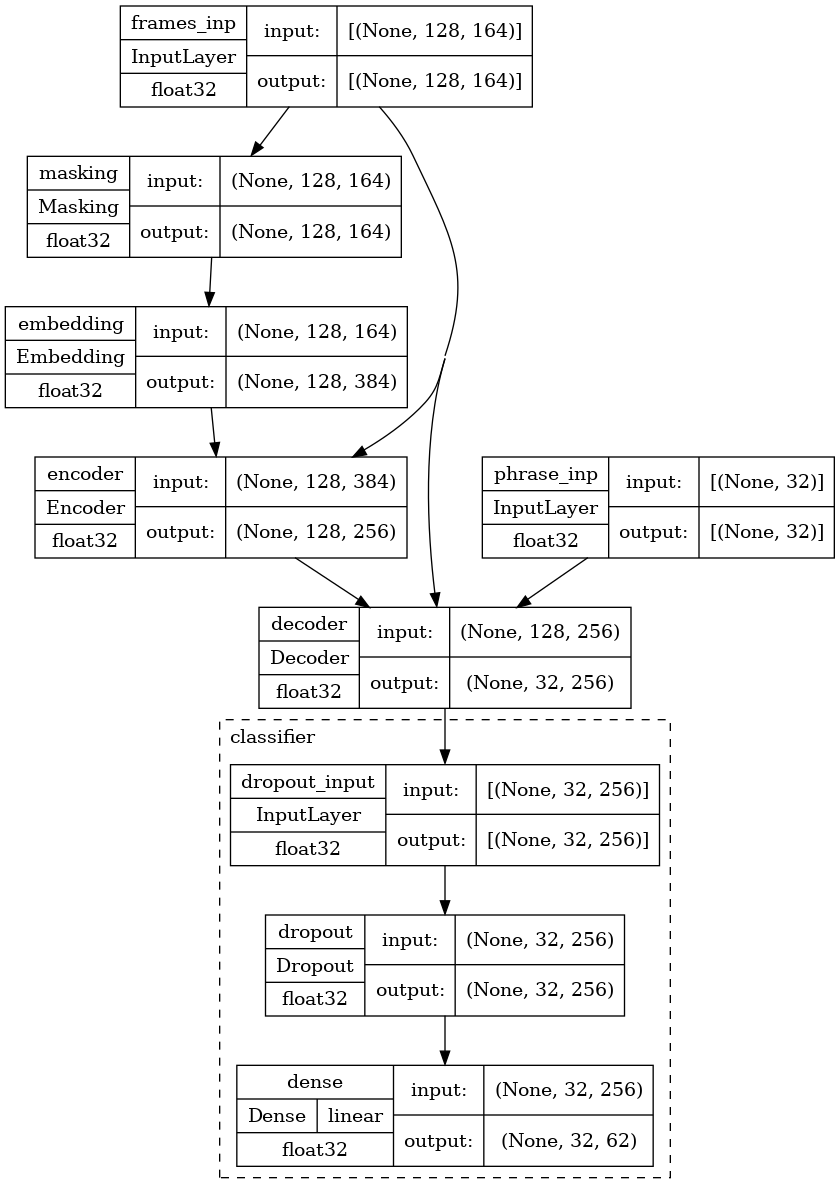

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

In [37]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=0.05):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames_inp (InputLayer)        [(None, 128, 164)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 128, 164)     0           ['frames_inp[0][0]']             
                                                                                                  
 embedding (Embedding)          (None, 128, 384)     259968      ['masking[0][0]']                
                                                                                                  
 encoder (Encoder)              (None, 128, 256)     3643392     ['embedding[0][0]',              
                                                                  'frames_inp[0][0]']         

In [39]:
tf.keras.backend.clear_session()

# Get new fresh model
epochs = 100
if DEBUG:
    epochs = 1
# Actual Training
history = model.fit(
        x=train_ds,
        epochs=epochs,
        validation_data=valid_ds,
        callbacks=[lr_callback, WeightDecayCallback()]
)

learning rate: 9.77e-07, weight decay: 4.88e-08
Epoch 1/100
1050/1050 [==============================] - 163s 135ms/step - loss: 4.5400 - top1acc: 0.0342 - top5acc: 0.1447 - val_loss: 3.8049 - val_top1acc: 0.1012 - val_top5acc: 0.3237 - lr: 9.7656e-07
learning rate: 1.95e-06, weight decay: 9.77e-08
Epoch 2/100
1050/1050 [==============================] - 145s 138ms/step - loss: 3.9169 - top1acc: 0.1052 - top5acc: 0.3305 - val_loss: 3.3973 - val_top1acc: 0.1779 - val_top5acc: 0.5139 - lr: 1.9531e-06
learning rate: 3.91e-06, weight decay: 1.95e-07
Epoch 3/100
1050/1050 [==============================] - 156s 148ms/step - loss: 3.6326 - top1acc: 0.1499 - top5acc: 0.4428 - val_loss: 3.2696 - val_top1acc: 0.2055 - val_top5acc: 0.5562 - lr: 3.9063e-06
learning rate: 7.81e-06, weight decay: 3.91e-07
Epoch 4/100
1050/1050 [==============================] - 162s 154ms/step - loss: 3.4949 - top1acc: 0.1699 - top5acc: 0.4851 - val_loss: 3.2163 - val_top1acc: 0.2236 - val_top5acc: 0.5714 - lr: 7.8

In [40]:
model.save_weights('model.h5')

In [41]:
model.evaluate(
    valid_ds,
    batch_size=batch_size,
)

15/15 [==============================] - 2s 86ms/step - loss: 1.8326 - top1acc: 0.8666 - top5acc: 0.9553


[1.832646369934082, 0.8666238784790039, 0.9553274512290955]

In [42]:
def outputs2phrase(outputs):
    if outputs.ndim == 2:
        outputs = np.argmax(outputs, axis=1)
    
    return ''.join([num_to_char.get(s, '') for s in outputs])

In [43]:
@tf.function(jit_compile=True)
def predict_phrase(frames):
    # Add Batch Dimension
    frames = tf.expand_dims(frames, axis=0)
    # Start Phrase
    phrase = tf.fill([1,max_tgt_length], char_to_num[PAD])

    for idx in tf.range(max_tgt_length):
        # Cast phrase to int8
        phrase = tf.cast(phrase, tf.int8)
        # Predict Next Token
        outputs = model({
            'frames': frames,
            'phrase': phrase,
        })

        # Add predicted token to input phrase
        phrase = tf.cast(phrase, tf.int32)
        phrase = tf.where(
            tf.range(max_tgt_length) < idx + 1,
            tf.argmax(outputs, axis=2, output_type=tf.int32),
            phrase,
        )

    # Squeeze outputs
    outputs = tf.squeeze(phrase, axis=0)
    outputs = tf.one_hot(outputs, vocab_size)

    # Return a dictionary with the output tensor
    return outputs

In [44]:
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(jit_compile=True)
    def encoder(self, x, frames_inp):
        x = self.model.get_layer('embedding')(x)
        x = self.model.get_layer('encoder')(x, frames_inp)
        
        return x
        
    @tf.function(jit_compile=True)
    def decoder(self, x, phrase_inp, frames_inp):
        x = self.model.get_layer('decoder')(x, phrase_inp, frames_inp)
        x = self.model.get_layer('classifier')(x)
        
        return x
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, ncols], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Number Of Input Frames
        N_INPUT_FRAMES = tf.shape(inputs)[0]
        # Preprocess Data
        frames_inp = self.preprocess_layer(inputs)        
        # Add Batch Dimension
        frames_inp = tf.expand_dims(frames_inp, axis=0)
        # Get Encoding
        encoding = self.encoder(frames_inp, frames_inp)
        # Make Prediction
        phrase = tf.fill([1,max_tgt_length], char_to_num[PAD])
        # Predict One Token At A Time
        stop = False
        
        for idx in tf.range(max_tgt_length):
            # Cast phrase to int8
            phrase = tf.cast(phrase, tf.int32)
            # If EOS token is predicted, stop predicting
            outputs = tf.cond(
                stop,
                lambda: tf.one_hot(tf.cast(phrase, tf.int32), vocab_size),
                lambda: self.decoder(encoding, phrase, frames_inp)
            )
            # Add predicted token to input phrase
            phrase = tf.cast(phrase, tf.int32)
            # Replcae PAD token with predicted token up to idx
            phrase = tf.where(
                tf.range(max_tgt_length) < idx + 1,
                tf.argmax(outputs, axis=2, output_type=tf.int32),
                phrase,
            )
            # Predicted Token
            predicted_token = phrase[0,idx]
            # If EOS (End Of Sentence) token is predicted stop
            if not stop:
                stop = predicted_token == char_to_num[EOS]
            
        # Squeeze outputs
        outputs = tf.squeeze(phrase, axis=0)
        outputs = tf.one_hot(outputs, vocab_size)
            
        # Return a dictionary with the output tensor
        return {'outputs': outputs }

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# Sanity Check
# demo_sequence_id = 1816796431
train_sequence_id = train_csv.set_index('sequence_id')
demo_sequence_id = sample_pq.index.unique()[0]
demo_raw_data = sample_pq.loc[demo_sequence_id, selected_columns_names].values
demo_phrase_true = train_sequence_id.loc[demo_sequence_id, 'phrase']
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)['outputs'].numpy()
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
print(f'demo_outputs phrase decoded: {outputs2phrase(demo_output)}')
print(f'phrase true: {demo_phrase_true}')

demo_raw_data shape: (123, 164), dtype: float32
demo_output shape: (32, 62), dtype: float32
demo_outputs phrase decoded: 3 creekhouse>PPPPPPPPPPPPPPPPPPP
phrase true: 3 creekhouse


In [45]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [46]:
with open('inference_args.json', 'w') as f:
     json.dump({ 'selected_columns': selected_columns_names}, f)

In [47]:
!zip submission.zip /kaggle/working/model.tflite /kaggle/working/inference_args.json

  adding: kaggle/working/model.tflite (deflated 9%)
  adding: kaggle/working/inference_args.json (deflated 83%)
